# Option 3: Data-Driven Functional Parcellation
Cluster voxels by response patterns in ses-01
Track cluster selectivity over time without anatomical assumptions

PROBLEM 1 WE'RE USING OR PLOTTING THE WRONG HEMISPHERE BELOW 
PROBLEM 2 WE'RE USING CONTRASTS FACE-WORD AND HOUSE-OBJECT BUT SHOULDN'T WE BE USING GENERAL COPES OR SOMETHING SIMILAR A FACE-WORD COPE (13/14) WOULD NOT HAVE OBJECT SELECTIVITY.

In [ ]:
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from nilearn import plotting

BASE_DIR = Path('/user_data/csimmon2/long_pt')

SUBJECTS = {
    'sub-004': {'code': 'UD', 'sessions': ['01', '02', '03', '05', '06'], 'hemi': 'left'},
    'sub-007': {'code': 'OT', 'sessions': ['01', '03', '04'], 'hemi': 'left'},
    'sub-021': {'code': 'TC', 'sessions': ['01', '02', '03'], 'hemi': 'right'}
}

print("Setup complete")

Setup complete


In [ ]:
# STEP 1: Load response patterns for 4 conditions in ses-01

def load_condition_responses(subject_id, session='01'):
    """Load activation for face, word, object, house conditions"""
    
    # Map conditions to copes (X > All contrasts)
    conditions = {
        'face': 6,
        'house': 7,
        'object': 8,
        'word': 9
    }
    
    # Load VOTC mask
    hemi = SUBJECTS[subject_id]['hemi']
    hemi_prefix = 'l' if hemi == 'left' else 'r'
    roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi_prefix}_VOTC_FG_OTS_mask.nii.gz'
    roi_img = nib.load(roi_file)
    roi_data = roi_img.get_fdata()
    voxel_indices = np.where(roi_data > 0)
    
    # Load activations
    response_matrix = []
    
    for condition, cope in conditions.items():
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{cope}.feat' / 'stats' / 'zstat1.nii.gz'
        
        if not zstat_file.exists():
            print(f"Warning: {zstat_file} not found")
            return None
        
        zstat_img = nib.load(zstat_file)
        zstat_data = zstat_img.get_fdata()
        
        # Extract voxel responses
        voxel_responses = zstat_data[voxel_indices]
        response_matrix.append(voxel_responses)
    
    # Shape: (n_voxels, n_conditions)
    response_matrix = np.column_stack(response_matrix)
    
    return {
        'responses': response_matrix,
        'voxel_indices': voxel_indices,
        'conditions': list(conditions.keys()),
        'reference': roi_img
    }

# Load for all subjects
ses01_data = {}
for subject_id in SUBJECTS.keys():
    print(f"Loading {subject_id}...")
    data = load_condition_responses(subject_id)
    if data:
        ses01_data[subject_id] = data
        print(f"  Loaded {data['responses'].shape[0]} voxels, {data['responses'].shape[1]} conditions")

Loading sub-004...
  Loaded 52114 voxels, 4 conditions
Loading sub-007...
  Loaded 61785 voxels, 4 conditions
Loading sub-021...
  Loaded 20403 voxels, 4 conditions


In [ ]:
# STEP 2: Cluster voxels by response patterns

N_CLUSTERS = 4  # Face, word, object, house

cluster_results = {}

for subject_id in ses01_data.keys():
    print(f"\nClustering {SUBJECTS[subject_id]['code']} ({subject_id})...")
    
    # Standardize responses
    scaler = StandardScaler()
    responses_scaled = scaler.fit_transform(ses01_data[subject_id]['responses'])
    
    # K-means clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=20)
    cluster_labels = kmeans.fit_predict(responses_scaled)
    
    # Compute cluster centers in original space
    cluster_centers = []
    cluster_sizes = []
    
    for i in range(N_CLUSTERS):
        cluster_voxels = ses01_data[subject_id]['responses'][cluster_labels == i]
        cluster_center = np.mean(cluster_voxels, axis=0)
        cluster_centers.append(cluster_center)
        cluster_sizes.append(len(cluster_voxels))
    
    cluster_centers = np.array(cluster_centers)
    
    # Identify cluster preferences
    conditions = ses01_data[subject_id]['conditions']
    cluster_preferences = []
    
    for i in range(N_CLUSTERS):
        max_idx = np.argmax(cluster_centers[i])
        preference = conditions[max_idx]
        cluster_preferences.append(preference)
        print(f"  Cluster {i}: {cluster_sizes[i]} voxels, prefers {preference}")
    
    cluster_results[subject_id] = {
        'labels': cluster_labels,
        'centers': cluster_centers,
        'preferences': cluster_preferences,
        'sizes': cluster_sizes
    }


Clustering UD (sub-004)...
  Cluster 0: 9454 voxels, prefers object
  Cluster 1: 17790 voxels, prefers word
  Cluster 2: 13714 voxels, prefers house
  Cluster 3: 11156 voxels, prefers object

Clustering OT (sub-007)...
  Cluster 0: 15776 voxels, prefers face
  Cluster 1: 30286 voxels, prefers house
  Cluster 2: 9802 voxels, prefers house
  Cluster 3: 5921 voxels, prefers face

Clustering TC (sub-021)...
  Cluster 0: 3367 voxels, prefers face
  Cluster 1: 7234 voxels, prefers object
  Cluster 2: 2920 voxels, prefers object
  Cluster 3: 6882 voxels, prefers object


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


<Figure size 1200x400 with 0 Axes>

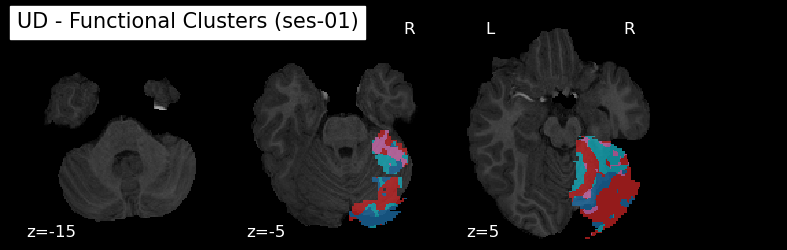

<Figure size 1200x400 with 0 Axes>

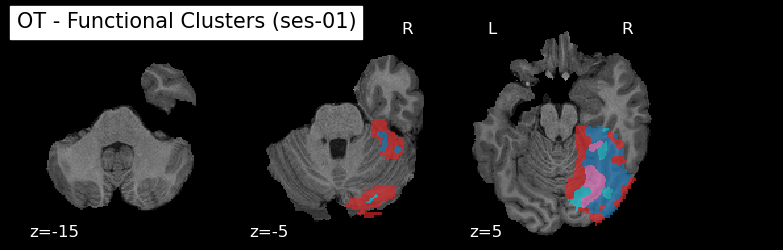

<Figure size 1200x400 with 0 Axes>

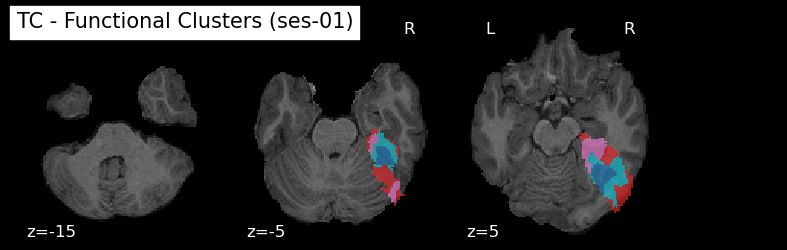

In [ ]:
# STEP 3: Visualize clusters in ses-01

for subject_id in cluster_results.keys():
    # Create cluster map
    cluster_map = np.zeros(ses01_data[subject_id]['reference'].shape)
    voxel_idx = ses01_data[subject_id]['voxel_indices']
    cluster_labels = cluster_results[subject_id]['labels']
    
    # Assign cluster numbers (1-4 for visibility)
    cluster_map[voxel_idx] = cluster_labels + 1
    
    cluster_img = nib.Nifti1Image(cluster_map, ses01_data[subject_id]['reference'].affine)
    
    # Plot
    fig = plt.figure(figsize=(12, 4))
    
    anat_file = BASE_DIR / subject_id / 'ses-01' / 'anat' / f'{subject_id}_ses-01_T1w_brain.nii.gz'
    
    display = plotting.plot_roi(
        cluster_img, bg_img=anat_file,
        display_mode='z', cut_coords=[-15, -5, 5],
        title=f'{SUBJECTS[subject_id]["code"]} - Functional Clusters (ses-01)',
        cmap='tab10'
    )
    
    # Add legend
    preferences = cluster_results[subject_id]['preferences']
    legend_text = '\n'.join([f"Cluster {i+1}: {pref}" for i, pref in enumerate(preferences)])
    plt.text(1.05, 0.5, legend_text, transform=plt.gca().transAxes, fontsize=10)
    
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_functional_clusters.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# STEP 4: Track cluster selectivity over time

def extract_cluster_selectivity(subject_id, session, cluster_label, contrast):
    """Extract selectivity for voxels in one cluster"""
    
    cope_map = {'face_word': 13, 'object_house': 14}
    cope_num = cope_map[contrast]
    
    zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                 'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
    
    if not zstat_file.exists():
        return None
    
    zstat_img = nib.load(zstat_file)
    zstat_data = zstat_img.get_fdata()
    
    # Get voxels in this cluster
    voxel_idx = ses01_data[subject_id]['voxel_indices']
    cluster_mask = cluster_results[subject_id]['labels'] == cluster_label
    
    # Extract from cluster voxels only
    cluster_voxel_idx = tuple(idx[cluster_mask] for idx in voxel_idx)
    cluster_values = zstat_data[cluster_voxel_idx]
    
    return cluster_values

# Track all clusters
cluster_timeseries = {}

for subject_id in cluster_results.keys():
    print(f"\nTracking clusters for {SUBJECTS[subject_id]['code']}...")
    cluster_timeseries[subject_id] = {}
    
    for contrast in ['face_word', 'object_house']:
        cluster_timeseries[subject_id][contrast] = {}
        
        for cluster_id in range(N_CLUSTERS):
            cluster_pref = cluster_results[subject_id]['preferences'][cluster_id]
            cluster_timeseries[subject_id][contrast][cluster_id] = {}
            
            for session in SUBJECTS[subject_id]['sessions']:
                values = extract_cluster_selectivity(subject_id, session, cluster_id, contrast)
                
                if values is not None:
                    cluster_timeseries[subject_id][contrast][cluster_id][session] = values.mean()
                    
            print(f"  Cluster {cluster_id} ({cluster_pref}) - {contrast}: tracked {len(cluster_timeseries[subject_id][contrast][cluster_id])} sessions")


Tracking clusters for UD...
  Cluster 0 (object) - face_word: tracked 5 sessions
  Cluster 1 (word) - face_word: tracked 5 sessions
  Cluster 2 (house) - face_word: tracked 5 sessions
  Cluster 3 (object) - face_word: tracked 5 sessions
  Cluster 0 (object) - object_house: tracked 5 sessions
  Cluster 1 (word) - object_house: tracked 5 sessions
  Cluster 2 (house) - object_house: tracked 5 sessions
  Cluster 3 (object) - object_house: tracked 5 sessions

Tracking clusters for OT...
  Cluster 0 (face) - face_word: tracked 3 sessions
  Cluster 1 (house) - face_word: tracked 3 sessions
  Cluster 2 (house) - face_word: tracked 3 sessions
  Cluster 3 (face) - face_word: tracked 3 sessions
  Cluster 0 (face) - object_house: tracked 3 sessions
  Cluster 1 (house) - object_house: tracked 3 sessions
  Cluster 2 (house) - object_house: tracked 3 sessions
  Cluster 3 (face) - object_house: tracked 3 sessions

Tracking clusters for TC...
  Cluster 0 (face) - face_word: tracked 3 sessions
  Cluste

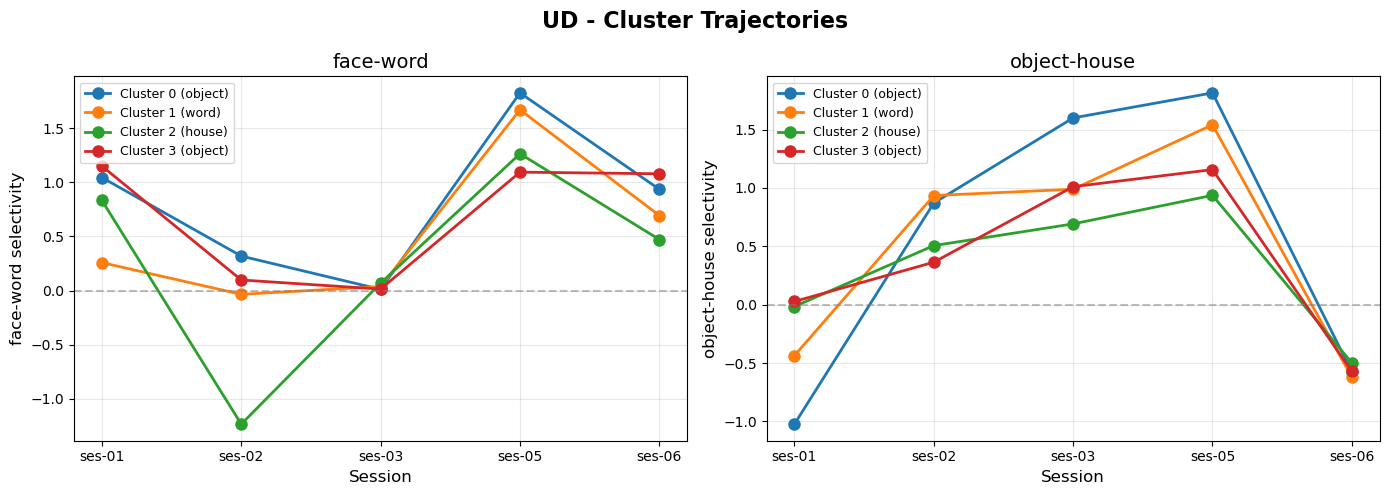

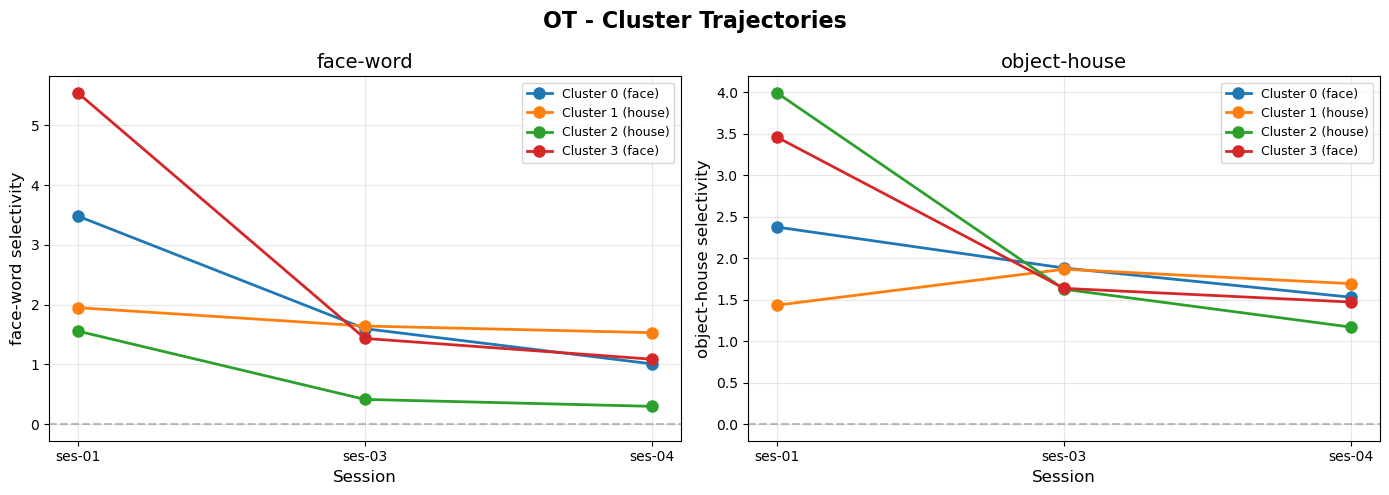

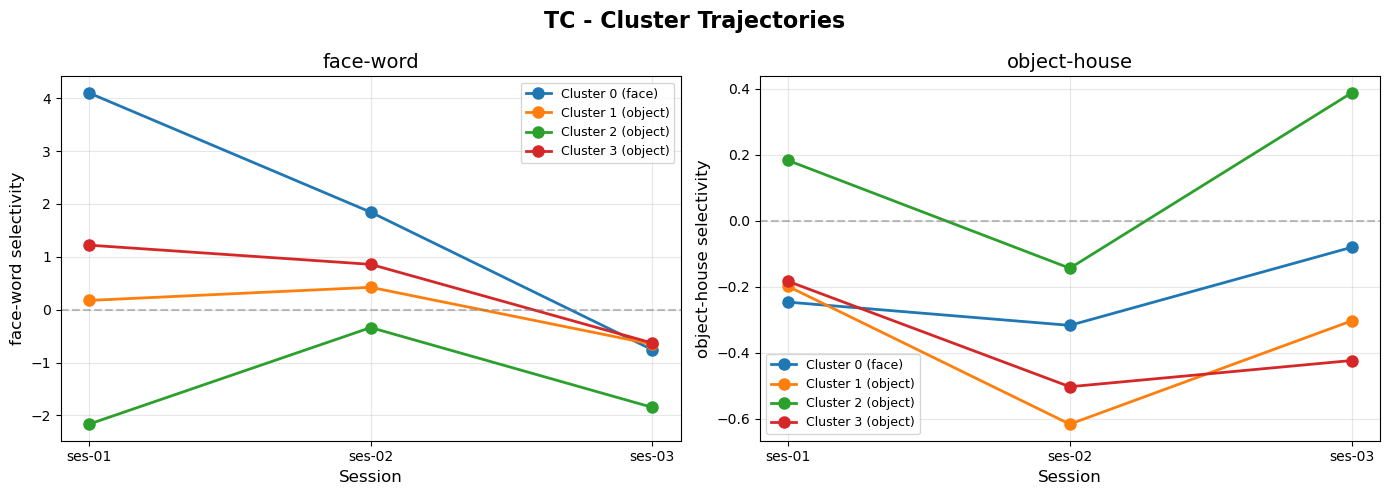

In [ ]:
# STEP 5: Visualize cluster trajectories

for subject_id in cluster_results.keys():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for contrast_idx, contrast in enumerate(['face_word', 'object_house']):
        ax = axes[contrast_idx]
        
        sessions = SUBJECTS[subject_id]['sessions']
        
        for cluster_id in range(N_CLUSTERS):
            cluster_pref = cluster_results[subject_id]['preferences'][cluster_id]
            
            # Get values across sessions
            values = []
            session_labels = []
            
            for ses in sessions:
                if ses in cluster_timeseries[subject_id][contrast][cluster_id]:
                    values.append(cluster_timeseries[subject_id][contrast][cluster_id][ses])
                    session_labels.append(ses)
            
            if values:
                ax.plot(range(len(values)), values, 'o-', 
                       label=f'Cluster {cluster_id} ({cluster_pref})',
                       linewidth=2, markersize=8)
        
        ax.set_xlabel('Session', fontsize=12)
        ax.set_ylabel(f'{contrast.replace("_", "-")} selectivity', fontsize=12)
        ax.set_xticks(range(len(sessions)))
        ax.set_xticklabels([f'ses-{s}' for s in sessions])
        ax.set_title(contrast.replace('_', '-'), fontsize=14)
        ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'{SUBJECTS[subject_id]["code"]} - Cluster Trajectories', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(BASE_DIR / 'analyses' / f'{subject_id}_cluster_trajectories.png', dpi=150)
    plt.show()

In [ ]:
# STEP 6: Statistical comparison of cluster changes

print("\n" + "="*60)
print("CLUSTER SELECTIVITY CHANGES")
print("="*60)

for subject_id in cluster_results.keys():
    print(f"\n{SUBJECTS[subject_id]['code']} ({subject_id}):")
    
    for contrast in ['face_word', 'object_house']:
        print(f"\n  {contrast}:")
        
        for cluster_id in range(N_CLUSTERS):
            cluster_pref = cluster_results[subject_id]['preferences'][cluster_id]
            
            sessions = sorted(cluster_timeseries[subject_id][contrast][cluster_id].keys())
            
            if len(sessions) >= 2:
                ses01_val = cluster_timeseries[subject_id][contrast][cluster_id]['01']
                last_ses = sessions[-1]
                last_val = cluster_timeseries[subject_id][contrast][cluster_id][last_ses]
                
                change = last_val - ses01_val
                
                print(f"    Cluster {cluster_id} ({cluster_pref}):")
                print(f"      ses-01: {ses01_val:.2f}, ses-{last_ses}: {last_val:.2f}")
                print(f"      Change: {change:+.2f}")


CLUSTER SELECTIVITY CHANGES

UD (sub-004):

  face_word:
    Cluster 0 (object):
      ses-01: 1.04, ses-06: 0.94
      Change: -0.11
    Cluster 1 (word):
      ses-01: 0.26, ses-06: 0.69
      Change: +0.43
    Cluster 2 (house):
      ses-01: 0.83, ses-06: 0.47
      Change: -0.36
    Cluster 3 (object):
      ses-01: 1.15, ses-06: 1.08
      Change: -0.07

  object_house:
    Cluster 0 (object):
      ses-01: -1.02, ses-06: -0.58
      Change: +0.45
    Cluster 1 (word):
      ses-01: -0.44, ses-06: -0.62
      Change: -0.19
    Cluster 2 (house):
      ses-01: -0.02, ses-06: -0.50
      Change: -0.48
    Cluster 3 (object):
      ses-01: 0.03, ses-06: -0.57
      Change: -0.60

OT (sub-007):

  face_word:
    Cluster 0 (face):
      ses-01: 3.48, ses-04: 1.01
      Change: -2.47
    Cluster 1 (house):
      ses-01: 1.95, ses-04: 1.53
      Change: -0.42
    Cluster 2 (house):
      ses-01: 1.56, ses-04: 0.30
      Change: -1.26
    Cluster 3 (face):
      ses-01: 5.54, ses-04: 1.

In [ ]:
# STEP 7: Summary - Compare cluster-based to whole ROI approach

print("\n" + "="*60)
print("SUMMARY: Data-Driven Parcellation")
print("="*60)
print("\nAdvantages:")
print("  - No anatomical assumptions")
print("  - Captures functional organization")
print("  - Tracks specific sub-regions")
print("\nLimitations:")
print("  - Clusters may not align with known ROIs")
print("  - Requires good ses-01 data")
print("  - Number of clusters arbitrary")
print("\nNext steps:")
print("  - Compare to anatomical ROI results")
print("  - Validate cluster preferences")
print("  - Test different cluster numbers")

print("\nAnalysis complete!")


SUMMARY: Data-Driven Parcellation

Advantages:
  - No anatomical assumptions
  - Captures functional organization
  - Tracks specific sub-regions

Limitations:
  - Clusters may not align with known ROIs
  - Requires good ses-01 data
  - Number of clusters arbitrary

Next steps:
  - Compare to anatomical ROI results
  - Validate cluster preferences
  - Test different cluster numbers

Analysis complete!
